# LAB06 Convolutional Neural Network (CNN)


```
11 Octorber 2024
Introduction to Machine Learning
```



### Google Drive Authentication

In [ ]:
# Access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigation to Dataset Folder
%cd drive/MyDrive/ # your_folder_path

[Errno 2] No such file or directory: 'drive/MyDrive/ # your_folder_path'
/content


### Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

In [ ]:


# นำเข้าไลบรารีที่จำเป็น
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


### Set parameters

In [ ]:
# พารามิเตอร์สำคัญ
IMG_SIZE = (224, 224)  # ขนาดภาพที่ต้องการ
BATCH_SIZE = 32  # ขนาด Batch
EPOCHS = 10  # จำนวนรอบการฝึก

### Prepare data with ImageDataGenerator

In [ ]:
# สร้างออบเจ็กต์ ImageDataGenerator สำหรับ Rescale ค่า Pixel
datagen = ImageDataGenerator(rescale=1.0/255)

# โหลดข้อมูลชุด Train
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/LAB06-DATASET/brain_mri2/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# โหลดข้อมูลชุด Validation
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/LAB06-DATASET/brain_mri2/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# โหลดข้อมูลชุด Test (ไม่ต้อง Shuffle)
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/LAB06-DATASET/brain_mri2/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 550 images belonging to 2 classes.
Found 156 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [ ]:
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Number of test samples:", test_generator.samples)

Number of training samples: 550
Number of validation samples: 156
Number of test samples: 82


### Load and Customize InceptionV3

In [ ]:
# โหลดโมเดล InceptionV3 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Train

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.6549 - loss: 0.9476 - val_accuracy: 0.8718 - val_loss: 0.3753
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - accuracy: 0.9190 - loss: 0.2036 - val_accuracy: 0.8846 - val_loss: 0.3265
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.9786 - loss: 0.1173 - val_accuracy: 0.8846 - val_loss: 0.3600
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9714 - loss: 0.1036 - val_accuracy: 0.8910 - val_loss: 0.2796
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9768 - loss: 0.0945 - val_accuracy: 0.9038 - val_loss: 0.3244
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.9745 - loss: 0.0897 - val_accuracy: 0.8974 - val_loss: 0.2546
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9895 - loss: 0.0527 - val_accuracy: 0.9103 - val_loss: 0.2434
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9955 - loss: 0.0283 - val_accuracy: 0.9295 - val_

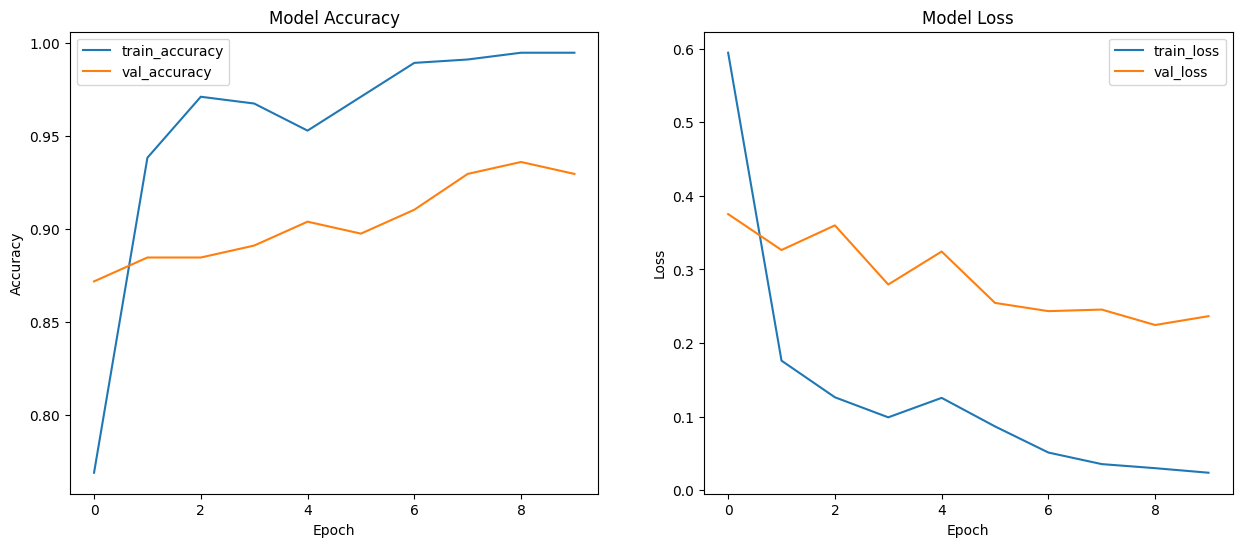

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()


### Evaluate model with test data

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.9165 - loss: 0.1157
Test Accuracy: 92.68%


### Export Model

In [ ]:
# บันทึกโมเดล
model.save('/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/model_inceptionv3_brain_mri.h5')


### Test model

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# โหลดโมเดลที่บันทึกไว้
model = load_model('/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/model_inceptionv3_brain_mri.h5')

# ฟังก์ชันสำหรับการพยากรณ์ภาพ
def predict_image(model, img_path, class_indices):
    # โหลดภาพและปรับขนาด
    img = load_img(img_path, target_size=(224, 224))  # ขนาดภาพตามที่โมเดลต้องการ
    img_array = img_to_array(img) / 255.0  # Normalize ค่า pixel เป็น 0-1
    img_array = np.expand_dims(img_array, axis=0)  # เพิ่มมิติให้เป็น (1, 224, 224, 3)

    # ทำนายผล
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # แปลงกลับจาก index เป็นชื่อคลาส
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class]

    print(f"Prediction: {predicted_label} (Confidence: {prediction[0][predicted_class] * 100:.2f}%)")

    return predicted_label


In [ ]:
# ตัวอย่างการเรียกใช้งาน
positive_path = '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/LAB06-DATASET/brain_mri2/test/positive/Te-meTr_0002.jpg'
normal_path = '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Lab - 06/LAB06-DATASET/brain_mri2/test/normal/Te-no_0093.jpg'

# เนื่องจาก class_indices เป็นสิ่งที่เกิดจากการสร้าง train_generator อาจต้องตั้งค่า manually หรือบันทึกไว้จาก training ก่อนหน้า
class_indices = {'normal': 0, 'positive': 1}

# พยากรณ์ภาพ
print("Test model with positive image")
predict_image(model, positive_path, class_indices)


Test model with positive image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: positive (Confidence: 96.90%)


'positive'

In [ ]:
# พยากรณ์ภาพ
print("\nTest model with normal image")
predict_image(model, normal_path, class_indices)


Test model with normal image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: normal (Confidence: 99.97%)


'normal'